<a href="https://colab.research.google.com/github/MandbeZ/TFM_sequia/blob/main/notebooks/4_1_Modelos_Estad%C3%ADsticos_ML__SPI_SPEI(Por_cluster).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalación de SKtime

In [ ]:
%pip install sktime
%pip install sktime[all_extras]
%pip install esig
%pip install utils

In [ ]:
from warnings import simplefilter
simplefilter(action="ignore", category=RuntimeWarning)

Importar librerías básicas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error,\
                                                   mean_absolute_error, mean_squared_error

# Naive Forecast / Pronóstico Ingenuo
from sktime.forecasting.naive import NaiveForecaster

# AutoARIMA
from sktime.forecasting.arima import AutoARIMA

# AutoETS
from sktime.forecasting.ets import AutoETS

# Algoritmos de Regresión de sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
t0 = pd.Timestamp.now()

In [ ]:
#Definición de funciones

def evaluar_modelo(test,pred):
  print('MAPE:',mean_absolute_percentage_error(test, pred, symmetric=False)) 
  print('SMAPE:',mean_absolute_percentage_error(test, pred)) #symmetric default=True
  print('MAE:',mean_absolute_error(test, pred) )
  print('RMSE:',mean_squared_error(test, pred, square_root=True) ) # square_root=True RMSE , false MSE)
  print('MSE:',mean_squared_error(test, pred, square_root=False) ) # square_root=True RMSE , false MSE)

def graficar_modelo(train,test,pred,titulo='Modelo',inicio_serie=200):
  plot_series(train[inicio_serie:], test, pred, labels=["y_train", "y_test", "y_pred"])
  plt.axhline(y=0.5, color='r', linestyle='dashed')
  plt.title(titulo)
  plt.show()


def graficar_cluster(train, test, pred, cl=0, tiulo='Modelo', ini=pd.NA):
    
    if pd.isna(ini): ini = int(0.94*len(train))

    plt.plot(train[ini:], label='train')
    plt.plot(test,label='test')
    plt.plot(pred, label='pred')
    plt.axhline(y=0.5, color='r', linestyle='dashed')

    plt.ylabel('cluster_'+str(cl))
    plt.title('Modelo arima')
    plt.rcParams["figure.figsize"] = (15,10)
    plt.legend()
    plt.show()


# 1. Cargar los datos de SPI

In [ ]:
def cargar_datos(archivo):
    data = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/' + archivo,  sep = ',', parse_dates=True)
    return data

# 2. Preprocesamiento de los datos

In [ ]:
'''Llevar la  fecha a índice, configurar como periodo'''
def procesa_datos(data):
    data['fecha'] = pd.to_datetime(data['fecha'])
    data = data.dropna()
    data = data.set_index('fecha')
    data.index = data.index.to_period('M')
    return data

## Normalizar los datos

In [ ]:
'''para mejores resultados se pueden normalizar los datos: [0,1]'''
def normalizar_datos(data):
    return (data - data.min()) / ( data.max() - data.min())

## Generar cluster

In [ ]:
'''Devuelve un Dataframe con todas las estaciones de un determinado cluster'''
def gen_cluster(lista_clust, clust, normalizados):
    estaciones = lista_clust[lista_clust['cluster'] == clust]
    nom_cols = [col for est in estaciones['id'] for col in normalizados.columns if str(est) in col]
    datos = normalizados[nom_cols]
    datos = datos.melt(value_name='valor').reset_index(drop=True)
    return datos.iloc[:, 1]

# 3. Dividir Datos en Entrenamiento y prueba

In [ ]:
'''Dividir el Dataset en Entrenamiento y prueba'''
def dividir_datos(serie, tamanio):
    y_train, y_test = temporal_train_test_split(serie, test_size=tamanio)
    return y_train, y_test

## Definir  el horizonte de predicción

In [ ]:
'''Definir horizonte de predicción'''
def horizon_prediccion(y_test):
    return ForecastingHorizon(y_test.index, is_relative=False)  

# 4. Configuración del algoritmo

In [ ]:
def config_algoritmo(algoritmo, estacionalidad = 12, ventana = 12, estrategia = 'mean'):
    if algoritmo=='naive': return NaiveForecaster(strategy=estrategia, sp=estacionalidad, window_length=ventana) #strategy="drift" o "last"  sp estacionalidad
    elif algoritmo=='arima': return AutoARIMA(sp=estacionalidad, suppress_warnings=True) #Cambiar sp para reducir el error
    elif algoritmo=='ets': return AutoETS(auto=True,sp=estacionalidad, n_jobs=-1) #sp=12

def config_algoritmoReg(algoritmo,ventana = 12, estrategia = 'recursive',estimadores=30, vecinos=11):
    if algoritmo=='LinearRegression':
        reg=LinearRegression()    
    elif algoritmo=='DecisionTreeRegressor': 
        reg=DecisionTreeRegressor()
    elif algoritmo=='KNeighborsRegressor':
        reg=KNeighborsRegressor(n_neighbors=vecinos)
    elif algoritmo=='RandomForestRegressor':
        reg=RandomForestRegressor(n_estimators=estimadores)
    return make_reduction(reg,strategy=estrategia, window_length=ventana)

# 5. Ajuste del Modelo

In [ ]:
def ajuste(predictor, y_train):
    return predictor.fit(y_train)

# 6. Predicción del Modelo

In [ ]:
def prediccion(predictor, horiz_prediccion):
    return predictor.predict(horiz_prediccion)

# 7. Evaluación del Modelo

In [ ]:
def evaluacion_modelo(test,pred):
    mape = mean_absolute_percentage_error(test, pred, symmetric=False)
    smape = mean_absolute_percentage_error(test, pred) #symmetric default=True
    mae = mean_absolute_error(test, pred) 
    rmse = mean_squared_error(test, pred, square_root=True) # square_root=True RMSE , false MSE)
    mse = mean_squared_error(test, pred, square_root=False) # square_root=True RMSE , false MSE)
    return [mape, smape, mae, rmse, mse]

# MODELOS ESTADÍSTICOS DE FORECASTING (SERIES TEMPORALES)

In [ ]:
'''cargar archivos con datos de cluster'''
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_5.csv',  sep = ',', usecols = {'id', 'cluster', 'nom'})

'''-- Declara DF para almacenar los y_pred,
      DF para almacenar los datos de la evaluacion'''
df_pred = pd.DataFrame()
df_eval = pd.DataFrame(index = ['MAPE','SMAPE','MAE','RMSE','MSE'])
columnas = []

'''Definir el horizonte de la prediccion'''
tam_ypred = 12
indice='spi'

'''Escala representa la escala temporal de SPI y SPEI = 3,6,9,12'''
for escala in [3,6,9,12]:
        
    '''1. Cargar archivo SPI-SPEI'''
    cad = indice+str(escala)
    datos = cargar_datos('indices_' +cad+ '.csv')

    '''2. Procesamiento de datos'''
    datos_procesados = procesa_datos(datos)

    '''-- Normalizar datos'''
    datos_normalizados = normalizar_datos(datos_procesados)
    
    '''definir los clusters'''
    lista_cluster = sorted(cluster['cluster'].unique())
    
    '''i representa el número de cluster'''
    for i in [0,2,3,4]:  # for i in  lista_cluster
        print('cluster N°',i)
        '''-- Trabajar con un cluster'''
        serie = gen_cluster(cluster, i, datos_normalizados)

        '''3. Datos de entrenamiento y prueba'''
        y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)

        '''Definir el horizonte de predicción'''
        horizonte_prediccion = horizon_prediccion(y_test)

        '''4. Configurar algoritmo, valores ['naive', 'arima', 'ets']'''
        predictor = config_algoritmo('arima', estacionalidad = 12, ventana = 48, estrategia = 'mean')

        '''5. Ajuste modelo'''
        predictor = ajuste(predictor, y_train)

        '''6. Predicción'''
        y_pred = prediccion(predictor, horizonte_prediccion)

        '''7. Evaluación'''
        datos_eval = evaluacion_modelo(y_test, y_pred)

        '''-- Almacenar todos los y_pred, datos_eval en DFs y nombre de columnas'''
        df_pred = pd.concat([df_pred, y_pred.reset_index(drop=True)], axis = 1)
        df_eval[indice+str(escala)+'_c'+str(i)] = datos_eval
        columnas.append(indice+str(escala)+'_c'+str(i))

'''Cambiar el nombre de las columnas'''
df_pred.columns = columnas
# df_pred.columns = ['predic_'+columna for columna in columnas] # Comentar E/RAM
# df_eval.columns = ['eval_'+columna for columna in columnas] # Comentar E/RAM


In [ ]:
# from google.colab import drive
# import pandas as pd
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# df_pred.to_csv('/content/drive/MyDrive/Colab Notebooks/predic_spi_arima_c.csv', index=False)
# df_eval.to_csv('/content/drive/MyDrive/Colab Notebooks/eval_spi_arima_c.csv', index=False)

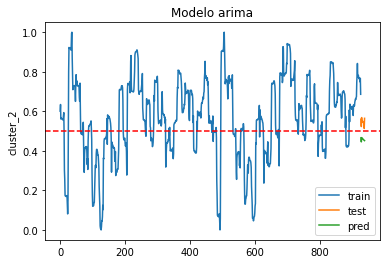

In [ ]:
#Gráfica de resultados de los modelos por cluster 0
cl = 2
serie = gen_cluster(cluster, cl, datos_normalizados)
train, test = dividir_datos(serie, tamanio = tam_ypred)

pred = df_pred.iloc[:,cl]
pred.index = test.index

graficar_cluster(train, test, pred, cl, 'Modelo', 0)

In [ ]:
df_pred.plot(subplots=True,figsize=(10,20))

In [ ]:
# def graficar_predicest(predic, clust=[0,1,2,3,4], escala=[3,6,9,12]):
predic = df_pred
clust=[0,1,2,3,4]
escala=[3,6,9,12]
print (predic.columns)
if 'spi' in predic.columns[0] : s = 'spi'
else : s = 'spei'

for e in escala:
  indice = [ind for ind in predic.columns if s+str(e) in ind]
  if not indice: 
    continue
  else:
    datos = cargar_datos('indices_'+s+str(e)+'.csv')
    p_datos = procesa_datos(datos)
    datos_normalizados=normalizar_datos(p_datos)

    for c in clust:
      cad = s+str(e)+'_c'+str(c)
      if (cad not in predic.columns):
        continue
      else:
        estaciones = cluster[cluster['cluster'] == c].reset_index(drop=True)
        

        for e in range(estaciones.shape[0]):
          estacion = [col for col in datos_normalizados.columns if str(estaciones['id'][e]) in col]
          serie = datos_normalizados.loc[:,estacion]
          train, test = dividir_datos(serie, tamanio = tam_ypred)
          pred = df_pred.iloc[:,1]
          pred.index = test.index
          nom_est = 'Estacion '+str(estaciones.iloc[e,0])+' '+estaciones.iloc[e,1]
          nom_clu = 'Cluster ' + str(c) + ' - '

          graficar_modelo(train,test,pred,titulo='Modelo Arima '+nom_clu+nom_est,inicio_serie=0)



In [ ]:
#Evaluación de los resultados del Modelo ARIMA para SPI
df_pred

,spi3_c0,spi3_c3,spi3_c4,spi12_c0,spi12_c3,spi12_c4
MAPE,0.220918,0.328147,0.164771,0.399379,0.317091,0.168727
SMAPE,0.188297,0.252663,0.149851,0.329530,0.267918,0.154347
MAE,0.085220,0.109915,0.084626,0.190841,0.106689,0.101212
RMSE,0.109154,0.144735,0.100171,0.195297,0.113500,0.105624
MSE,0.011915,0.020948,0.010034,0.038141,0.012882,0.011156


In [ ]:
#Evaluación de los resultados del Modelo ARIMA para SPEI
df_eval

,30,32,33,34,60,62,63,64,90,92,93,94,120,122,123,124
MAPE,0.117712,0.118865,0.249260,0.132724,0.202979,0.133867,0.277189,0.108194,0.181222,0.202422,0.494896,0.151625,0.170001,0.154821,0.369437,0.133713
SMAPE,0.101833,0.120333,0.202897,0.140091,0.178024,0.124098,0.230964,0.112557,0.163313,0.179760,0.385860,0.138459,0.155601,0.143509,0.308723,0.125002
MAE,0.043378,0.061236,0.079453,0.076154,0.074187,0.060823,0.086504,0.059445,0.078461,0.101179,0.155972,0.083643,0.082387,0.084223,0.126176,0.080897
RMSE,0.068539,0.077980,0.103938,0.091977,0.086070,0.072933,0.100773,0.076981,0.089610,0.112205,0.164018,0.090961,0.086074,0.084856,0.128678,0.082551
MSE,0.004698,0.006081,0.010803,0.008460,0.007408,0.005319,0.010155,0.005926,0.008030,0.012590,0.026902,0.008274,0.007409,0.007201,0.016558,0.006815


# ALGORITMOS DE REGRESIÓN DE APRENDIZAJE AUTOMÁTICO

In [ ]:
cluster = pd.read_csv('https://raw.githubusercontent.com/MandbeZ/TFM_sequia/main/datos/spi_spei/cluster_5.csv',  sep = ',', usecols = {'id', 'cluster'})

'''-- Declara DF para almacenar los y_pred,
      DF para almacenar los datos de la evaluacion'''
df_pred = pd.DataFrame()
df_eval = pd.DataFrame(index = ['MAPE','SMAPE','MAE','RMSE','MSE'])
columnas = []

'''Definir el horizonte de la prediccion'''
tam_ypred = 12

for escala in [3,6,9,12]:
        
    '''1. Cargar archivo'''
    cad = 'spi'+str(escala)
    datos = cargar_datos('indices_' +cad+ '.csv')

    '''2. Procesamiento de datos'''
    datos_procesados = procesa_datos(datos)

    '''-- Normalizar datos'''
    datos_normalizados = normalizar_datos(datos_procesados)    
    
    '''definir los clusters'''
    lista_cluster = sorted(cluster['cluster'].unique())
    for i in lista_cluster:

        '''-- Trabajar con un cluster'''
        serie = gen_cluster(cluster, i, datos_normalizados)

        '''3. Datos de entrenamiento y prueba'''
        y_train, y_test = dividir_datos(serie, tamanio = tam_ypred)

        '''Definir el horizonte de predicción'''
        horizonte_prediccion = horizon_prediccion(y_test)

        '''4. Configurar algoritmo de regresión, valores ['LinearRegression', 'DecisionTreeRegressor','RandomForestRegressor', 'KNeighborsRegressor']'''
        predictor = config_algoritmoReg('RandomForestRegressor',  ventana = 48, estrategia = 'recursive',estimadores=30, vecinos=11)

        '''5. Ajuste modelo'''
        predictor = ajuste(predictor, y_train)

        '''6. Predicción'''
        y_pred = prediccion(predictor, horizonte_prediccion)

        '''7. Evaluación'''
        datos_eval = evaluacion_modelo(y_test, y_pred)

        '''-- Almacenar todos los y_pred, datos_eval en DFs y nombre de columnas'''
        df_pred = pd.concat([df_pred, y_pred.reset_index(drop=True)], axis = 1)
        df_eval[str(escala)+str(i)] = datos_eval
        columnas.append(cad+'_clus'+str(i))
        
'''Cambiar el nombre de las columnas'''
df_pred.columns = ['predic_'+columna for columna in columnas]
df_eval.columns = ['eval_'+columna for columna in columnas]



In [ ]:
df_pred.to_csv('/drive/MyDrive/Colab Notebooks/pred_spi_rf_c.csv', index=False)
df_eval.to_csv('/drive/MyDrive/Colab Notebooks/eval_spi_rf_c.csv', index=False)

In [ ]:
# c indica el cluster de 0 a n para los n cluster
c = 2
# estacion indica la estacion de 0 a m para las m estaciones dentro del cluster "c"
estac = 0
estaciones = cluster[cluster['cluster'] == c].reset_index(drop=True)
estacion = [col for col in datos_normalizados.columns if str(estaciones['id'][estac]) in col]
serie = datos_normalizados.loc[:,estacion]
train, test = dividir_datos(serie, tamanio = tam_ypred)
pred = df_pred.iloc[:,0]
pred.index = test.index

graficar_modelo(train,test,pred,titulo='Modelo',inicio_serie=0)
graficar_modelo(train,test,pred,titulo='Modelo',inicio_serie=400)